## Setup and Package Verification

Before we begin, let's verify that all required packages are installed and working properly.

In [1]:
# Package verification and imports
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")
print("\n" + "=" * 70)
print("Checking required packages...")
print("=" * 70 + "\n")

required_packages = {
    'numpy': 'numerical computing',
    'pandas': 'data manipulation',
    'matplotlib': 'plotting and visualization',
    'sklearn': 'machine learning utilities',
}

optional_packages = {
    'faiss': 'vector search (optional but recommended)',
}

# Check required packages
all_good = True
for package, description in required_packages.items():
    try:
        mod = __import__(package)
        version = getattr(mod, '__version__', 'unknown')
        print(f"✅ {package:15s} {version:15s} - {description}")
    except ImportError:
        print(f"❌ {package:15s} NOT FOUND - {description}")
        all_good = False

print()

# Check optional packages
for package, description in optional_packages.items():
    try:
        mod = __import__(package)
        version = getattr(mod, '__version__', 'unknown')
        print(f"✅ {package:15s} {version:15s} - {description}")
    except ImportError:
        print(f"⚠️  {package:15s} NOT FOUND - {description}")
        print(f"   Install with: conda install -c conda-forge faiss-cpu")

print("\n" + "=" * 70)
if all_good:
    print("✅ All required packages are installed! Ready to proceed.")
else:
    print("❌ Some required packages are missing. Please install them first.")
print("=" * 70)

Python version: 3.10.11 (main, May 15 2023, 19:29:30) [Clang 14.0.6 ]
Python executable: /Users/sanjeev/miniconda3/bin/python

Checking required packages...

✅ numpy           1.24.3          - numerical computing
✅ numpy           1.24.3          - numerical computing
✅ pandas          1.5.3           - data manipulation
✅ matplotlib      3.10.0          - plotting and visualization
✅ pandas          1.5.3           - data manipulation
✅ matplotlib      3.10.0          - plotting and visualization
✅ sklearn         1.1.3           - machine learning utilities

✅ sklearn         1.1.3           - machine learning utilities

✅ faiss           1.9.0           - vector search (optional but recommended)

✅ All required packages are installed! Ready to proceed.
✅ faiss           1.9.0           - vector search (optional but recommended)

✅ All required packages are installed! Ready to proceed.


**Last updated:** October 2025 • **Reading time:** ~15 minutes

---

Vector databases power the "semantic" layer of modern AI systems. Instead of matching exact strings, they compare embeddings—high-dimensional vectors that capture meaning from text, images, audio, code, molecules, and more. This post explains how vector DBs work, when to use them, what can go wrong, and how to build & operate them in production.

# What is a Vector Database?

A **vector database** stores and indexes embeddings—dense vectors (e.g., 384–4096 dimensions) produced by models such as:
- Sentence transformers
- CLIP (vision-language models)
- Whisper (audio)
- Multimodal foundation models
- Domain-specific encoders

The core task is **nearest neighbor search**: given a query vector, return the most similar stored vectors under a metric (cosine, L2, inner product).

## Why vectors?
Because similar concepts map to nearby points in embedding space. "puppy on grass" and "dog on lawn" sit close even if they share few keywords.

In [2]:
# Example: Creating simple embeddings to demonstrate vector similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Simulated embeddings for demonstration (in reality, these come from models)
embeddings = {
    "puppy on grass": np.array([0.8, 0.6, 0.3, 0.5]),
    "dog on lawn": np.array([0.75, 0.65, 0.35, 0.52]),
    "cat in house": np.array([0.3, 0.2, 0.9, 0.1]),
    "car on road": np.array([0.1, 0.15, 0.2, 0.95])
}

# Calculate similarity between "puppy on grass" and other phrases
query = embeddings["puppy on grass"].reshape(1, -1)

print("Similarity scores to 'puppy on grass':\n")
for phrase, vec in embeddings.items():
    if phrase != "puppy on grass":
        similarity = cosine_similarity(query, vec.reshape(1, -1))[0][0]
        print(f"{phrase:20s}: {similarity:.4f}")

Similarity scores to 'puppy on grass':

dog on lawn         : 0.9972
cat in house        : 0.6027
car on road         : 0.6168


# End-to-End Flow

The vector database workflow consists of five key stages:

## Vectorization
Unstructured data → embedding model → vector $\mathbf{x} \in \mathbb{R}^d$.

Often you also normalize: $\mathbf{x} \leftarrow \frac{\mathbf{x}}{\|\mathbf{x}\|}$ if using cosine similarity.

## Storage & Metadata
Store `{id, vector, metadata, payload}`. Metadata enables filters (e.g., `country=US`, `doc_type=blog`) and post-retrieval ranking.

## Indexing
Build an **ANN (Approximate Nearest Neighbor)** index so queries don't scan every vector. Trade speed for a controlled loss vs exact search.

## Query
Query text/image → query vector $\mathbf{q}$. Perform ANN search with optional metadata filters and hybrid fusion (keyword + vector).

## Ranking & Fusion
Compute similarity scores, apply re-ranking (e.g., LTR, cross-encoder), dedupe near-duplicates, then return references/snippets.

In [3]:
# Example: End-to-end vector database flow simulation
import numpy as np
from sklearn.preprocessing import normalize

# Step 1: Vectorization (simulated embeddings)
documents = [
    "Machine learning with neural networks",
    "Deep learning for computer vision",
    "Natural language processing with transformers",
    "Database systems and indexing",
    "Vector search and embeddings"
]

# Simulate embedding generation (in practice, use real models like sentence-transformers)
np.random.seed(42)
dim = 128
doc_embeddings = np.random.randn(len(documents), dim).astype('float32')

# Step 2: Normalize for cosine similarity
doc_embeddings = normalize(doc_embeddings, norm='l2', axis=1)

# Step 3: Store with metadata
metadata = [
    {"doc_id": i, "category": "ML", "year": 2024} 
    for i in range(len(documents))
]

print(f"Stored {len(documents)} documents with {dim}-dimensional embeddings")
print(f"Embedding shape: {doc_embeddings.shape}")
print(f"Sample embedding (first 10 dims): {doc_embeddings[0][:10]}")

Stored 5 documents with 128-dimensional embeddings
Embedding shape: (5, 128)
Sample embedding (first 10 dims): [ 0.04642567 -0.01292295  0.06053658  0.14235085 -0.02188528 -0.02188374
  0.14760202  0.07172872 -0.04387969  0.05071068]


# Distance Metrics & Their Gotchas

Choosing the right distance metric is crucial for vector search performance.

## Cosine Similarity

$$s(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x} \cdot \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}$$

**Properties:**
- Invariant to magnitude
- Great for text embeddings
- Normalize vectors for fast dot-product equivalence

## Euclidean Distance (L2)

$$d(\mathbf{x}, \mathbf{y}) = \|\mathbf{x} - \mathbf{y}\|_2 = \sqrt{\sum_{i=1}^{d} (x_i - y_i)^2}$$

**Properties:**
- Sensitive to magnitude
- Useful when norms carry signal (e.g., certain vision or embedding regimes)

## Inner Product (MIPS - Maximum Inner Product Search)

$$\text{MIPS}(\mathbf{x}, \mathbf{y}) = \mathbf{x} \cdot \mathbf{y}$$

**Properties:**
- Equivalent to cosine if vectors are normalized
- If not normalized, may use transform tricks (e.g., add a norm-dependent extra dimension) to reuse L2 engines

**💡 Tip:** Decide metric before index build; many indexes are metric-specific.

In [4]:
# Comparing different distance metrics
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt

# Create two sample vectors
vec1 = np.array([[1.0, 2.0, 3.0]])
vec2 = np.array([[2.0, 4.0, 6.0]])  # Same direction, different magnitude
vec3 = np.array([[1.0, 2.0, -3.0]]) # Different direction

# Normalize vectors for cosine
vec1_norm = vec1 / np.linalg.norm(vec1)
vec2_norm = vec2 / np.linalg.norm(vec2)
vec3_norm = vec3 / np.linalg.norm(vec3)

print("Distance Metrics Comparison:\n")
print("=" * 60)

# Cosine similarity
cos_sim_12 = cosine_similarity(vec1, vec2)[0][0]
cos_sim_13 = cosine_similarity(vec1, vec3)[0][0]
print(f"Cosine Similarity:")
print(f"  vec1 vs vec2 (same direction): {cos_sim_12:.4f}")
print(f"  vec1 vs vec3 (diff direction): {cos_sim_13:.4f}")

# Euclidean distance
l2_dist_12 = euclidean_distances(vec1, vec2)[0][0]
l2_dist_13 = euclidean_distances(vec1, vec3)[0][0]
print(f"\nEuclidean Distance (L2):")
print(f"  vec1 vs vec2: {l2_dist_12:.4f}")
print(f"  vec1 vs vec3: {l2_dist_13:.4f}")

# Inner product
inner_12 = np.dot(vec1, vec2.T)[0][0]
inner_13 = np.dot(vec1, vec3.T)[0][0]
print(f"\nInner Product:")
print(f"  vec1 vs vec2: {inner_12:.4f}")
print(f"  vec1 vs vec3: {inner_13:.4f}")

print("\n" + "=" * 60)
print("\n💡 Notice: Cosine sees vec1 and vec2 as identical (both 1.0)")
print("   because they point in the same direction, despite magnitude difference!")

Distance Metrics Comparison:

Cosine Similarity:
  vec1 vs vec2 (same direction): 1.0000
  vec1 vs vec3 (diff direction): -0.2857

Euclidean Distance (L2):
  vec1 vs vec2: 3.7417
  vec1 vs vec3: 6.0000

Inner Product:
  vec1 vs vec2: 28.0000
  vec1 vs vec3: -4.0000


💡 Notice: Cosine sees vec1 and vec2 as identical (both 1.0)
   because they point in the same direction, despite magnitude difference!


# Index Families (and When to Use Them)

Different indexing strategies optimize for various trade-offs between speed, accuracy, and memory.

## Graph-based (HNSW - Hierarchical Navigable Small World)

**Pros:**
- Excellent recall/speed trade-off
- Dynamic insert capabilities
- Strong default for ≤ few hundred million points in RAM

**Cons:**
- Memory-heavy (stores graph structure)
- Deletions are lazy or complicated
- Filtering can be non-trivial

## Inverted File (IVF) + [PQ/OPQ]

Cluster vectors into `nlist` centroids (coarse quantizer), search only a few lists (`nprobe`). Optional **Product Quantization (PQ)** to compress.

**Pros:**
- Scales well to billions of vectors
- Great for GPU acceleration (e.g., FAISS)
- Good recall/latency trade-off
- Compresses memory usage

**Cons:**
- Build time can be significant
- Requires tuning `nlist`, `nprobe`, and PQ bits
- Recall loss under heavy compression

## Tree-like (Annoy)

**Pros:**
- Simple implementation
- Memory-mapped for efficient disk usage
- Good for read-mostly workloads

**Cons:**
- Slower writes
- Less optimal for dynamic updates

## Specialized Indexes

- **ScaNN:** Anisotropic quantization for better compression
- **DiskANN:** I/O-aware for large-scale cloud disk storage
- **Flat/Brute-force:** Exact search, costly but useful for small collections or re-ranking

## Rule of Thumb

| Scale | Recommendation |
|-------|---------------|
| Up to tens of millions in RAM | **HNSW** |
| Hundreds of millions / GPU | **IVF-PQ** with FAISS or vendor GPU index |
| On disk at web scale | **DiskANN**-style or sharded IVF-PQ + caching |

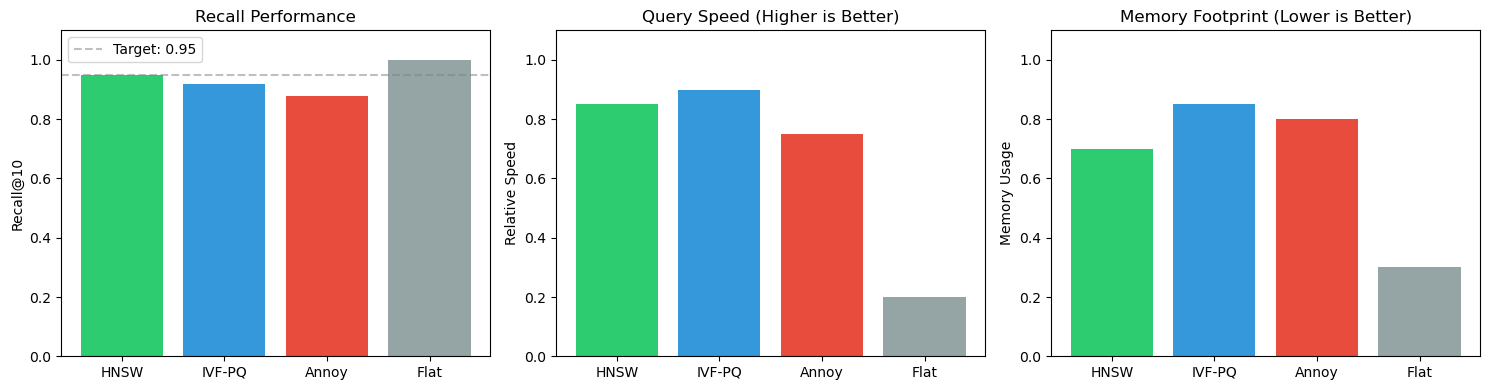


📊 Index Performance Summary:
HNSW       | Recall: 0.95 | Speed: 0.85 | Memory: 0.70
IVF-PQ     | Recall: 0.92 | Speed: 0.90 | Memory: 0.85
Annoy      | Recall: 0.88 | Speed: 0.75 | Memory: 0.80
Flat       | Recall: 1.00 | Speed: 0.20 | Memory: 0.30


In [5]:
# Visualizing index performance characteristics
import matplotlib.pyplot as plt
import numpy as np

# Simulated performance characteristics
index_types = ['HNSW', 'IVF-PQ', 'Annoy', 'Flat']
recall = [0.95, 0.92, 0.88, 1.0]
speed = [0.85, 0.90, 0.75, 0.20]  # queries per second (normalized)
memory = [0.70, 0.85, 0.80, 0.30]  # memory efficiency (lower is better for memory)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Recall comparison
axes[0].bar(index_types, recall, color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
axes[0].set_ylabel('Recall@10')
axes[0].set_title('Recall Performance')
axes[0].set_ylim([0, 1.1])
axes[0].axhline(y=0.95, color='gray', linestyle='--', alpha=0.5, label='Target: 0.95')
axes[0].legend()

# Speed comparison
axes[1].bar(index_types, speed, color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
axes[1].set_ylabel('Relative Speed')
axes[1].set_title('Query Speed (Higher is Better)')
axes[1].set_ylim([0, 1.1])

# Memory efficiency
axes[2].bar(index_types, memory, color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
axes[2].set_ylabel('Memory Usage')
axes[2].set_title('Memory Footprint (Lower is Better)')
axes[2].set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('index_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n📊 Index Performance Summary:")
print("=" * 60)
for i, idx in enumerate(index_types):
    print(f"{idx:10s} | Recall: {recall[i]:.2f} | Speed: {speed[i]:.2f} | Memory: {memory[i]:.2f}")
print("=" * 60)

# Deep Dive: How HNSW Works

**Hierarchical Navigable Small World (HNSW)** builds a multi-layer graph for efficient approximate nearest neighbor search.

## Architecture

- Each vector is a node
- At the **top layers**, only a few nodes exist (sparse)
- At the **bottom layer**, all nodes exist (dense)
- Multiple layers create a hierarchical structure for fast navigation

## Key Parameters

| Parameter | Description | Impact |
|-----------|-------------|--------|
| **M** | Max neighbors per node | Controls graph degree, recall, memory |
| **efConstruction** | Candidate list during build | Higher = better recall, slower build, more memory |
| **efSearch** | Candidate list during query | Higher = better recall, higher latency |

## Insertion Process

1. **Assign layer**: Random maximum layer to the new node (geometric distribution)
2. **Start descent**: Begin from entry point in the top layer
3. **Greedy descent**: At each layer, move to neighbors closer to the new vector
4. **Link nodes**: At target layer, link the node to its nearest neighbors using diversification heuristic (prune overly redundant edges)
5. **Repeat down**: Continue process down through all layers

## Search Process

1. **Start at top**: Begin at the top entry point
2. **Greedy search per layer**: Move to the neighbor closest to query $\mathbf{q}$ until no improvement
3. **Descend**: Move down one layer
4. **Refine at bottom**: At the bottom layer, perform best-first search with bounded candidate set size `efSearch`
5. **Return top-k**: Return the k nearest neighbors

## Intuition

- **Upper layers** "teleport" you near the right region (coarse navigation)
- **Bottom layer** refines the search (fine-grained precision)

## Trade-offs

- Larger `M`, `efConstruction`, `efSearch` → **higher recall & memory/latency**
- **Complexity**: Near log-like behavior empirically
- **Memory**: $\approx O(N \times M)$ edges + vectors

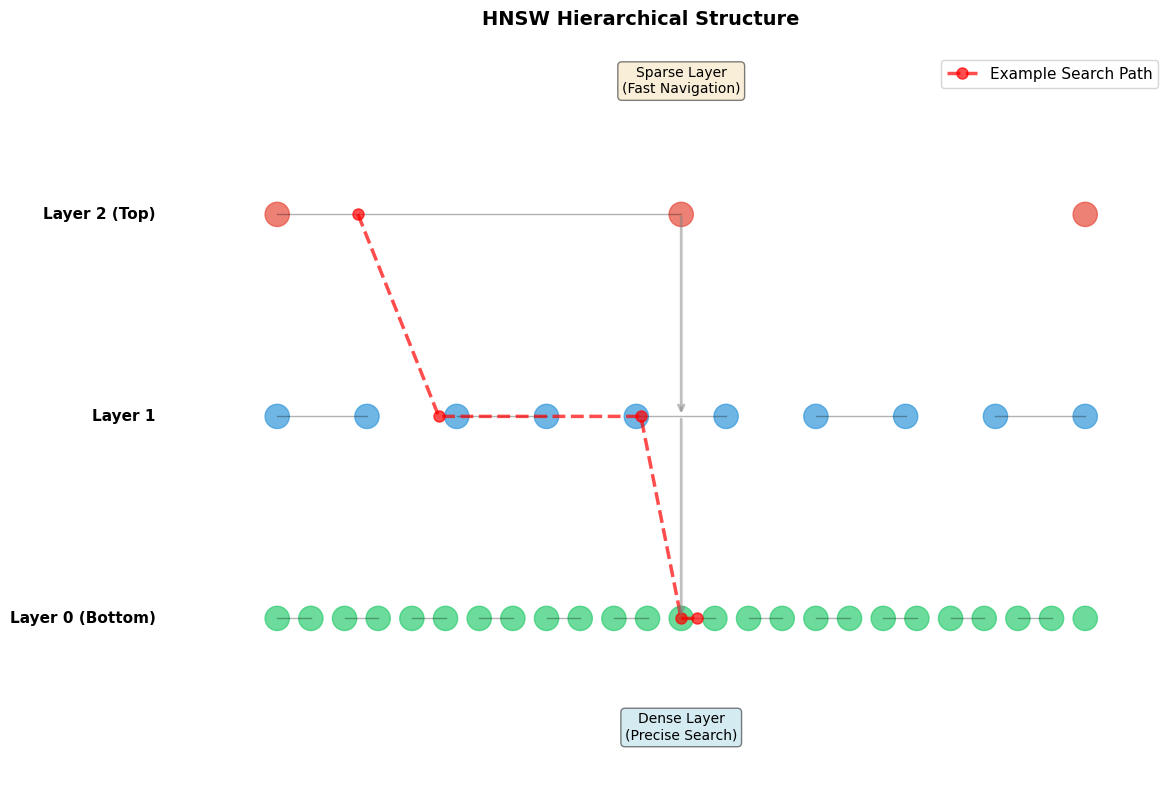


🏗️ HNSW Structure Explained:
• Top layers: Few nodes, long-distance hops (coarse search)
• Bottom layer: All nodes, short hops (fine-grained search)
• Search starts at top and descends layer by layer
• Each layer acts as a 'highway' to quickly reach the target region


In [6]:
# Visualizing HNSW layer structure
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))

# Define layers
layers = [
    {"name": "Layer 2 (Top)", "y": 7, "nodes": 3, "color": "#e74c3c"},
    {"name": "Layer 1", "y": 4.5, "nodes": 10, "color": "#3498db"},
    {"name": "Layer 0 (Bottom)", "y": 2, "nodes": 25, "color": "#2ecc71"}
]

# Draw layers
for layer in layers:
    # Draw nodes
    x_positions = np.linspace(1, 11, layer["nodes"])
    y_pos = layer["y"]
    
    for x in x_positions:
        circle = plt.Circle((x, y_pos), 0.15, color=layer["color"], alpha=0.7)
        ax.add_patch(circle)
    
    # Draw some connections (simplified)
    if layer["nodes"] > 1:
        for i in range(len(x_positions) - 1):
            if i % 2 == 0 and i + 1 < len(x_positions):
                ax.plot([x_positions[i], x_positions[i+1]], [y_pos, y_pos], 
                       'k-', alpha=0.3, linewidth=1)
    
    # Label layer
    ax.text(-0.5, y_pos, layer["name"], fontsize=11, fontweight='bold', 
            va='center', ha='right')

# Draw vertical connections between layers
ax.annotate('', xy=(6, 4.5), xytext=(6, 7),
            arrowprops=dict(arrowstyle='->', color='gray', lw=2, alpha=0.5))
ax.annotate('', xy=(6, 2), xytext=(6, 4.5),
            arrowprops=dict(arrowstyle='->', color='gray', lw=2, alpha=0.5))

# Add annotations
ax.text(6, 8.5, 'Sparse Layer\n(Fast Navigation)', ha='center', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(6, 0.5, 'Dense Layer\n(Precise Search)', ha='center', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Add search path illustration
search_path_x = [2, 3, 5.5, 6, 6.2]
search_path_y = [7, 4.5, 4.5, 2, 2]
ax.plot(search_path_x, search_path_y, 'r--', linewidth=2.5, alpha=0.7, 
        marker='o', markersize=8, label='Example Search Path')

ax.set_xlim(-1, 12)
ax.set_ylim(0, 9)
ax.set_aspect('equal')
ax.axis('off')
ax.legend(loc='upper right', fontsize=11)
ax.set_title('HNSW Hierarchical Structure', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('hnsw_structure.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n🏗️ HNSW Structure Explained:")
print("=" * 60)
print("• Top layers: Few nodes, long-distance hops (coarse search)")
print("• Bottom layer: All nodes, short hops (fine-grained search)")
print("• Search starts at top and descends layer by layer")
print("• Each layer acts as a 'highway' to quickly reach the target region")
print("=" * 60)

# Beyond RAG: What Else Uses Vector Databases?

Vector databases power far more than just Retrieval-Augmented Generation. Here are key application areas:

## Recommendation & Personalization
Retrieve similar users/items, complementing traditional collaborative filtering approaches.

## Near-Duplicate & Plagiarism Detection
Deduplicate large corpora (news articles, code repositories, scientific preprints).

## Anomaly/Outlier Detection
"Distance from manifold" heuristics for fraud detection, abuse prevention, or quality control.

## Semantic Monitoring & Alerting
Watch streams (logs, support tickets) for semantically similar incidents to trigger alerts.

## Multimodal Search
- Image ↔ Text (CLIP-based)
- Audio snippet search
- Video moment retrieval

## Code Intelligence
- Similar function lookup
- Cross-repository code search
- Code clone detection

## Bio/Chem Applications
- Protein/compound embeddings for virtual screening
- Scaffold hopping in drug discovery
- Molecular similarity search

## Robotics/SLAM & Mapping
Place recognition via local feature embeddings for autonomous navigation.

## Legal & E-discovery
Concept clustering and semantic curation of legal documents.

## Content Moderation
Identify similar policy-violating content across platforms.

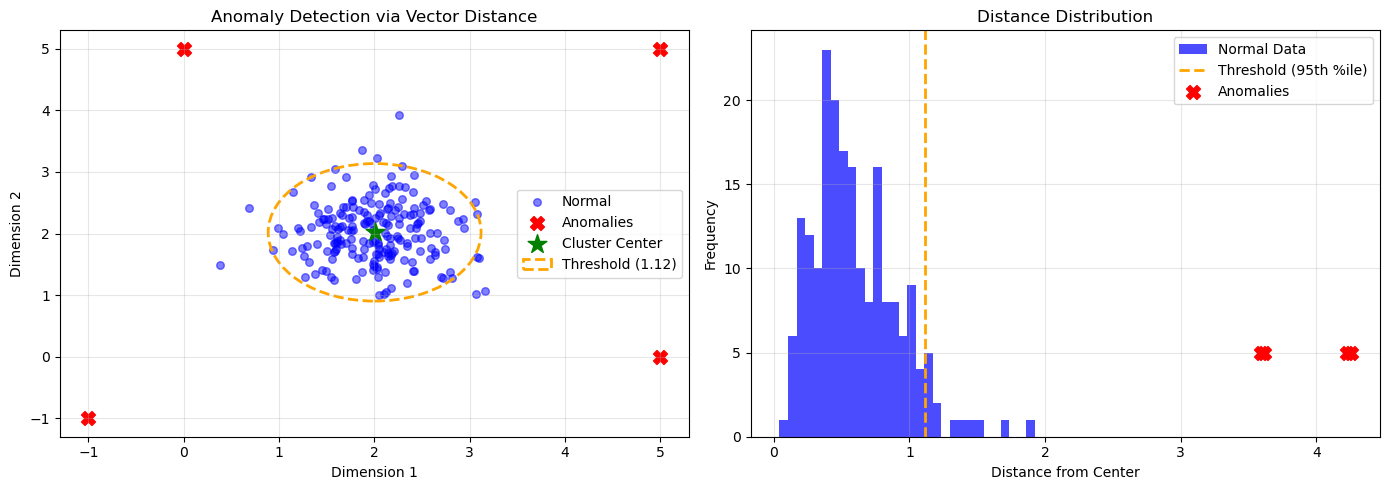


🔍 Anomaly Detection Results:
Cluster center: [2.00317112 2.01937749]
Distance threshold: 1.1167

Normal data distances (mean ± std): 0.5999 ± 0.3162
Anomaly distances: [4.22671195 3.5912122  3.61370569 4.25860038]

Detected 4 anomalies out of 4


In [7]:
# Example: Anomaly detection using vector distances
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Generate normal data (cluster)
np.random.seed(42)
normal_data = np.random.randn(200, 2) * 0.5 + np.array([2, 2])

# Generate anomalies (outliers)
anomalies = np.array([
    [5, 5],
    [0, 5],
    [5, 0],
    [-1, -1]
])

# Calculate distances from cluster center
center = np.mean(normal_data, axis=0)
distances_normal = np.linalg.norm(normal_data - center, axis=1)
distances_anomaly = np.linalg.norm(anomalies - center, axis=1)

# Set threshold (e.g., 95th percentile of normal distances)
threshold = np.percentile(distances_normal, 95)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot
ax1.scatter(normal_data[:, 0], normal_data[:, 1], c='blue', alpha=0.5, 
           label='Normal', s=30)
ax1.scatter(anomalies[:, 0], anomalies[:, 1], c='red', s=100, 
           label='Anomalies', marker='X')
ax1.scatter(center[0], center[1], c='green', s=200, marker='*', 
           label='Cluster Center')
circle = plt.Circle(center, threshold, color='orange', fill=False, 
                   linewidth=2, linestyle='--', label=f'Threshold ({threshold:.2f})')
ax1.add_patch(circle)
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.set_title('Anomaly Detection via Vector Distance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Distance distribution
ax2.hist(distances_normal, bins=30, alpha=0.7, label='Normal Data', color='blue')
ax2.axvline(threshold, color='orange', linestyle='--', linewidth=2, 
           label=f'Threshold (95th %ile)')
ax2.scatter(distances_anomaly, [5]*len(distances_anomaly), c='red', 
           s=100, marker='X', label='Anomalies', zorder=5)
ax2.set_xlabel('Distance from Center')
ax2.set_ylabel('Frequency')
ax2.set_title('Distance Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anomaly_detection.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n🔍 Anomaly Detection Results:")
print("=" * 60)
print(f"Cluster center: {center}")
print(f"Distance threshold: {threshold:.4f}")
print(f"\nNormal data distances (mean ± std): {distances_normal.mean():.4f} ± {distances_normal.std():.4f}")
print(f"Anomaly distances: {distances_anomaly}")
print(f"\nDetected {np.sum(distances_anomaly > threshold)} anomalies out of {len(distances_anomaly)}")
print("=" * 60)

# Hybrid Search & Filters (Real-World Must-Haves)

Pure vector scores are powerful, but structured filters and keywords are essential for production systems.

## Metadata Filters at Retrieval Time

Filter results based on structured attributes:
```python
filters = {
    "lang": "en",
    "published_after": "2024-01-01",
    "category": ["ML", "AI"],
    "verified": True
}
```

## Hybrid Fusion Strategies

### A. Rank Fusion (RRF - Reciprocal Rank Fusion)
Combine BM25 (keyword) and vector top-k lists:

$$\text{RRF}(d) = \sum_{r \in R} \frac{1}{k + r(d)}$$

where $r(d)$ is the rank of document $d$ in ranking $r$, and $k$ is typically 60.

### B. Score Fusion
Weighted sum after re-scaling:

$$\text{score}_{\text{final}} = \alpha \cdot \text{score}_{\text{vector}} + (1 - \alpha) \cdot \text{score}_{\text{keyword}}$$

### C. Neural Re-rankers
Cross-encoders (e.g., MS MARCO–style) on the top 100 to boost precision@k.

## Implementation Considerations

**Caveat:** Some ANN structures don't natively support filters. Common approaches:

- **Pre-filtering:** Filter candidates before ANN search (may reduce recall)
- **Post-filtering:** Search larger candidate set, then filter (increases latency)
- **Filter-aware IVF lists:** Maintain per-segment indexes
- **Partitioned indexes:** Separate indexes per common filter values

## When to Use What

| Use Case | Strategy |
|----------|----------|
| Few filters, high selectivity | Pre-filtering |
| Many filters, low selectivity | Post-filtering with larger k |
| Common filter patterns | Partitioned indexes |
| Strict latency requirements | Filter-aware indexes + caching |

In [8]:
# Example: Reciprocal Rank Fusion (RRF)
import numpy as np
import pandas as pd

def reciprocal_rank_fusion(rankings_list, k=60):
    """
    Combine multiple rankings using Reciprocal Rank Fusion.
    
    Args:
        rankings_list: List of rankings, where each ranking is a list of doc IDs
        k: Constant (typically 60)
    
    Returns:
        Combined ranking with RRF scores
    """
    scores = {}
    
    for ranking in rankings_list:
        for rank, doc_id in enumerate(ranking, start=1):
            if doc_id not in scores:
                scores[doc_id] = 0
            scores[doc_id] += 1 / (k + rank)
    
    # Sort by score descending
    sorted_docs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_docs

# Simulate two different ranking systems
# BM25 (keyword-based) ranking
bm25_ranking = ['doc3', 'doc1', 'doc5', 'doc2', 'doc7', 'doc4', 'doc6']

# Vector similarity ranking
vector_ranking = ['doc1', 'doc2', 'doc3', 'doc4', 'doc5', 'doc8', 'doc9']

# Apply RRF
fused_results = reciprocal_rank_fusion([bm25_ranking, vector_ranking], k=60)

# Display results
print("\n🔍 Hybrid Search: Reciprocal Rank Fusion\n")
print("=" * 70)
print("\nBM25 Ranking (Keyword-based):")
print(f"  {', '.join(bm25_ranking)}")
print("\nVector Ranking (Semantic):")
print(f"  {', '.join(vector_ranking)}")
print("\n" + "=" * 70)
print("\nFused Ranking (RRF):\n")

# Create a nice table
results_df = pd.DataFrame(fused_results, columns=['Document', 'RRF Score'])
results_df.index = range(1, len(results_df) + 1)
results_df['RRF Score'] = results_df['RRF Score'].round(6)

print(results_df.to_string())
print("\n" + "=" * 70)
print("\n💡 Notice how documents appearing in both rankings get boosted!")
print("   doc1, doc2, doc3 all rank higher in the fused results.")


🔍 Hybrid Search: Reciprocal Rank Fusion


BM25 Ranking (Keyword-based):
  doc3, doc1, doc5, doc2, doc7, doc4, doc6

Vector Ranking (Semantic):
  doc1, doc2, doc3, doc4, doc5, doc8, doc9


Fused Ranking (RRF):

  Document  RRF Score
1     doc1   0.032522
2     doc3   0.032266
3     doc2   0.031754
4     doc5   0.031258
5     doc4   0.030777
6     doc7   0.015385
7     doc8   0.015152
8     doc6   0.014925
9     doc9   0.014925


💡 Notice how documents appearing in both rankings get boosted!
   doc1, doc2, doc3 all rank higher in the fused results.


# Data & Model Concerns

Getting embeddings right is crucial for vector database performance.

## Embedding Model Selection

**Domain-specific encoders beat generic models:**
- Scientific papers: SciBERT, PubMedBERT
- Code: CodeBERT, GraphCodeBERT
- Legal: LegalBERT
- Multilingual: mBERT, XLM-RoBERTa

## Normalization Consistency

**Critical:** Be consistent across index & query
- Cosine similarity requires normalized vectors
- MIPS equivalence depends on normalization
- Mixing normalized and unnormalized vectors breaks retrieval

## Drift & Versioning

**Challenge:** New models produce incompatible embeddings

**Solutions:**
- Keep vector schema version metadata
- Maintain multiple indexes during transition
- Re-index incrementally (dual-write pattern)
- A/B test new embeddings before full rollout

## Chunking for Text

**Key considerations:**
- **Window size:** 256–1024 tokens common
- **Stride/Overlap:** 20–30% overlap prevents information loss at boundaries
- **Chunk re-assembly:** Maintain document relationships
- **Context preservation:** Include surrounding context in metadata

## Deduplication & Collapse

**Prevent duplicate retrieval:**
- Store fingerprints (SimHash/MinHash)
- Cluster near-duplicates
- Post-process to remove redundant results
- Maintain canonical document IDs

In [9]:
# Example: Text chunking strategies
def chunk_text_with_overlap(text, chunk_size=100, overlap=20):
    """
    Split text into overlapping chunks.
    
    Args:
        text: Input text string
        chunk_size: Size of each chunk in characters
        overlap: Overlap between consecutive chunks
    
    Returns:
        List of text chunks
    """
    chunks = []
    start = 0
    
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append({
            'chunk_id': len(chunks),
            'text': chunk,
            'start_pos': start,
            'end_pos': min(end, len(text)),
            'length': len(chunk)
        })
        start += (chunk_size - overlap)
    
    return chunks

# Example text
sample_text = """Vector databases are specialized systems designed to store and query 
high-dimensional vectors efficiently. These vectors, or embeddings, are dense numerical 
representations of data such as text, images, or audio. The key advantage of vector 
databases is their ability to perform semantic search, finding similar items based on 
meaning rather than exact keyword matches. This makes them essential for modern AI 
applications including recommendation systems, similarity search, and retrieval-augmented 
generation (RAG) systems."""

# Create chunks with different strategies
chunks_no_overlap = chunk_text_with_overlap(sample_text, chunk_size=100, overlap=0)
chunks_with_overlap = chunk_text_with_overlap(sample_text, chunk_size=100, overlap=20)

print("\n📄 Text Chunking Strategies\n")
print("=" * 70)
print(f"\nOriginal text length: {len(sample_text)} characters\n")

print("Strategy 1: No Overlap")
print(f"  → {len(chunks_no_overlap)} chunks created")
for i, chunk in enumerate(chunks_no_overlap[:3], 1):
    print(f"\nChunk {i} (chars {chunk['start_pos']}-{chunk['end_pos']}):")
    print(f"  {chunk['text'][:50]}...")

print("\n" + "-" * 70)

print("\n\nStrategy 2: With 20% Overlap")
print(f"  → {len(chunks_with_overlap)} chunks created")
for i, chunk in enumerate(chunks_with_overlap[:3], 1):
    print(f"\nChunk {i} (chars {chunk['start_pos']}-{chunk['end_pos']}):")
    print(f"  {chunk['text'][:50]}...")

print("\n" + "=" * 70)
print("\n💡 Benefits of overlap:")
print("  • Prevents information loss at chunk boundaries")
print("  • Maintains context across chunks")
print("  • Improves retrieval recall for cross-boundary concepts")


📄 Text Chunking Strategies


Original text length: 531 characters

Strategy 1: No Overlap
  → 6 chunks created

Chunk 1 (chars 0-100):
  Vector databases are specialized systems designed ...

Chunk 2 (chars 100-200):
  iently. These vectors, or embeddings, are dense nu...

Chunk 3 (chars 200-300):
  ges, or audio. The key advantage of vector 
databa...

----------------------------------------------------------------------


Strategy 2: With 20% Overlap
  → 7 chunks created

Chunk 1 (chars 0-100):
  Vector databases are specialized systems designed ...

Chunk 2 (chars 80-180):
  sional vectors efficiently. These vectors, or embe...

Chunk 3 (chars 160-260):
  epresentations of data such as text, images, or au...


💡 Benefits of overlap:
  • Prevents information loss at chunk boundaries
  • Maintains context across chunks
  • Improves retrieval recall for cross-boundary concepts


# Evaluation: Quantify "Good"

Measuring vector database performance requires multiple metrics across different dimensions.

## Retrieval Quality Metrics

### Recall@k
$$\text{Recall@k} = \frac{\text{# relevant items in top-k}}{\text{total # relevant items}}$$

Measures what fraction of relevant items are retrieved in top-k results. Compare against exact search or high-ef baseline.

### NDCG (Normalized Discounted Cumulative Gain)
$$\text{NDCG@k} = \frac{\text{DCG@k}}{\text{IDCG@k}}$$

where $\text{DCG@k} = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i + 1)}$

Accounts for position and relevance grades (not just binary relevant/irrelevant).

### MRR (Mean Reciprocal Rank)
$$\text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rank}_i}$$

Measures the average inverse rank of the first relevant result.

## Performance Metrics

- **Latency:** P50/P95/P99 under production load
- **QPS (Queries Per Second):** Throughput capacity
- **Index build time:** Time to build/rebuild indexes
- **Memory footprint:** RAM/GPU per million vectors

## Cost Metrics

- **Infrastructure cost:** $/query or $/million vectors
- **Operational overhead:** Maintenance, monitoring, updates
- **Storage cost:** Disk, RAM, GPU requirements

## Business Metrics (A/B Testing)

- **Click-through rate (CTR):** User engagement with results
- **Success rate:** Task completion percentage
- **Dwell time:** Time spent with retrieved content
- **User satisfaction:** Direct feedback or NPS scores

## Evaluation Best Practices

1. **Establish baselines:** Always compare against exact search
2. **Use holdout sets:** Avoid overfitting to test queries
3. **Monitor in production:** Online metrics often differ from offline
4. **Track over time:** Detect drift and degradation
5. **Segment analysis:** Different query types may have different performance


📊 Evaluation Metrics Examples


Query 1:
  Retrieved: ['doc3', 'doc1', 'doc5', 'doc2', 'doc7', 'doc4']
  Relevant:  ['doc1', 'doc2', 'doc4']
  Recall@3:  0.3333
  Recall@5:  0.6667
  NDCG@5:    0.6078

Query 2:
  Retrieved: ['doc8', 'doc6', 'doc9', 'doc2', 'doc1']
  Relevant:  ['doc1', 'doc2']
  Recall@3:  0.0000
  Recall@5:  1.0000
  NDCG@5:    0.4695

Mean Reciprocal Rank (MRR): 0.3750



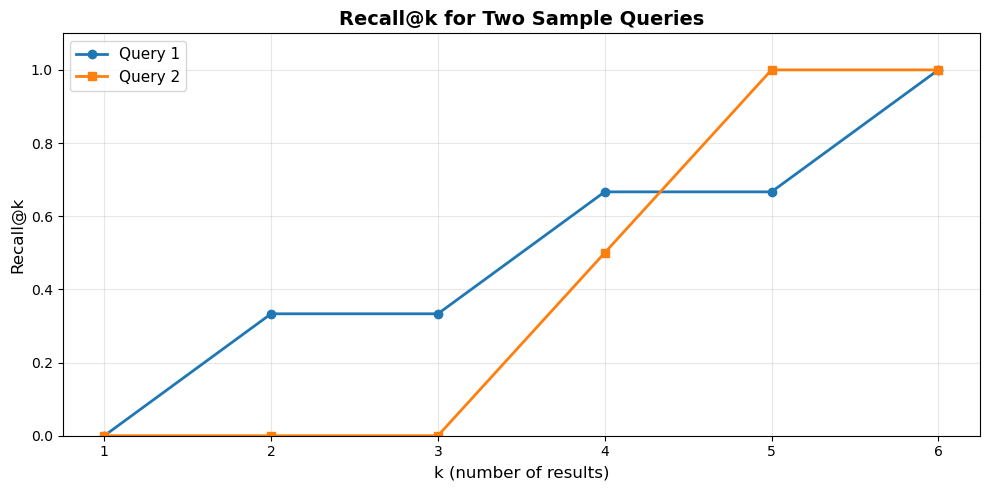

In [10]:
# Example: Computing evaluation metrics
import numpy as np

def recall_at_k(retrieved, relevant, k):
    """Calculate Recall@k"""
    retrieved_k = set(retrieved[:k])
    relevant_set = set(relevant)
    return len(retrieved_k & relevant_set) / len(relevant_set) if relevant_set else 0

def dcg_at_k(relevance_scores, k):
    """Calculate DCG@k"""
    relevance_scores = np.array(relevance_scores[:k])
    gains = 2**relevance_scores - 1
    discounts = np.log2(np.arange(2, len(relevance_scores) + 2))
    return np.sum(gains / discounts)

def ndcg_at_k(retrieved_relevance, ideal_relevance, k):
    """Calculate NDCG@k"""
    dcg = dcg_at_k(retrieved_relevance, k)
    idcg = dcg_at_k(sorted(ideal_relevance, reverse=True), k)
    return dcg / idcg if idcg > 0 else 0

def mrr(retrieved_lists, relevant_lists):
    """Calculate Mean Reciprocal Rank"""
    reciprocal_ranks = []
    for retrieved, relevant in zip(retrieved_lists, relevant_lists):
        relevant_set = set(relevant)
        for rank, item in enumerate(retrieved, 1):
            if item in relevant_set:
                reciprocal_ranks.append(1 / rank)
                break
        else:
            reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks)

# Example data
# Query 1
retrieved_1 = ['doc3', 'doc1', 'doc5', 'doc2', 'doc7', 'doc4']
relevant_1 = ['doc1', 'doc2', 'doc4']
relevance_scores_1 = [0, 3, 0, 2, 0, 1]  # Graded relevance (0-3 scale)

# Query 2
retrieved_2 = ['doc8', 'doc6', 'doc9', 'doc2', 'doc1']
relevant_2 = ['doc1', 'doc2']
relevance_scores_2 = [0, 0, 0, 3, 2]

print("\n📊 Evaluation Metrics Examples\n")
print("=" * 70)

# Calculate metrics for Query 1
print("\nQuery 1:")
print(f"  Retrieved: {retrieved_1}")
print(f"  Relevant:  {relevant_1}")
print(f"  Recall@3:  {recall_at_k(retrieved_1, relevant_1, 3):.4f}")
print(f"  Recall@5:  {recall_at_k(retrieved_1, relevant_1, 5):.4f}")
print(f"  NDCG@5:    {ndcg_at_k(relevance_scores_1, relevance_scores_1, 5):.4f}")

print("\nQuery 2:")
print(f"  Retrieved: {retrieved_2}")
print(f"  Relevant:  {relevant_2}")
print(f"  Recall@3:  {recall_at_k(retrieved_2, relevant_2, 3):.4f}")
print(f"  Recall@5:  {recall_at_k(retrieved_2, relevant_2, 5):.4f}")
print(f"  NDCG@5:    {ndcg_at_k(relevance_scores_2, relevance_scores_2, 5):.4f}")

# MRR across both queries
mrr_score = mrr([retrieved_1, retrieved_2], [relevant_1, relevant_2])
print(f"\nMean Reciprocal Rank (MRR): {mrr_score:.4f}")

print("\n" + "=" * 70)

# Visualize recall@k
import matplotlib.pyplot as plt

k_values = range(1, 7)
recall_1 = [recall_at_k(retrieved_1, relevant_1, k) for k in k_values]
recall_2 = [recall_at_k(retrieved_2, relevant_2, k) for k in k_values]

plt.figure(figsize=(10, 5))
plt.plot(k_values, recall_1, marker='o', label='Query 1', linewidth=2)
plt.plot(k_values, recall_2, marker='s', label='Query 2', linewidth=2)
plt.xlabel('k (number of results)', fontsize=12)
plt.ylabel('Recall@k', fontsize=12)
plt.title('Recall@k for Two Sample Queries', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xticks(k_values)
plt.ylim([0, 1.1])
plt.tight_layout()
plt.savefig('recall_at_k.png', dpi=100, bbox_inches='tight')
plt.show()

# Operating at Scale

Production vector databases require careful operational planning.

## Index Build & Updates

**Batch Operations:**
- Offline batch build for major changes
- Schedule during low-traffic periods
- Use distributed build for large datasets

**Streaming Updates:**
- Real-time upserts for freshness requirements
- Balance throughput vs consistency
- Monitor lag between write and searchability

**Delete Handling:**
- Lazy deletes with tombstone markers
- Background consolidation/compaction
- Plan for periodic full rebuilds

**Deployment Strategy:**
- Keep read replicas for zero-downtime updates
- Blue/green deployment for index version changes
- Gradual rollout with traffic splitting

## Sharding Strategies

**Hash Sharding:**
- Uniform distribution by document ID
- Simple routing logic
- Good for load balancing

**Semantic Sharding:**
- Partition by domain/topic/category
- Improves cache locality
- Enables targeted search

**Query Routing:**
- Coarse hash for uniform shards
- Routing model for semantic shards
- Fan-out to multiple shards when needed

## Caching Strategies

**Query Vector Cache:**
- Cache embeddings for popular queries
- LRU eviction policy
- Shared across replicas

**Result Cache:**
- Cache complete search results
- Short TTL for dynamic data
- Invalidate on updates

**Precomputation:**
- Pre-embed frequent query patterns
- Materialize popular aggregations
- Scheduled refresh

## Hardware Considerations

**GPU vs CPU:**
- **GPU:** Excellent for IVF-PQ, flat re-rank, large batch queries
- **CPU:** Fine for HNSW, lower QPS, memory-optimized workloads

**Memory Architecture:**
- Watch NUMA placement for multi-socket systems
- Leverage SIMD instructions (AVX-512, NEON)
- Monitor memory bandwidth bottlenecks

**Storage Tiers:**
- Hot data in RAM/GPU memory
- Warm data on NVMe SSD
- Cold data on HDD or object storage

## Security & Compliance

**Data Protection:**
- Encryption at rest and in transit
- Field-level encryption for sensitive data
- Secure key management

**Access Control:**
- Row-level ACLs for multi-tenancy
- Attribute-based access control (ABAC)
- API key rotation policies

**Compliance:**
- Right-to-be-forgotten requires true deletion
- Audit logs for all access
- Data residency requirements
- GDPR, CCPA, HIPAA considerations


🔀 Sharding Strategies Comparison


Hash-based Sharding:
  Shard 0: ['doc5', 'doc6', 'doc7']
  Shard 1: ['doc2', 'doc4']
  Shard 2: ['doc1', 'doc3', 'doc8']

Semantic Sharding (by category):
  Shard 0 [ML]: ['doc1 (ML)', 'doc2 (ML)', 'doc7 (ML)']
  Shard 1 [DB]: ['doc3 (DB)', 'doc4 (DB)', 'doc8 (DB)']
  Shard 2 [NLP]: ['doc5 (NLP)', 'doc6 (NLP)']


💡 Trade-offs:
  • Hash sharding: Uniform load, requires fan-out for category queries
  • Semantic sharding: Targeted queries, but potential load imbalance
  • Hybrid: Use semantic for common patterns, hash for others


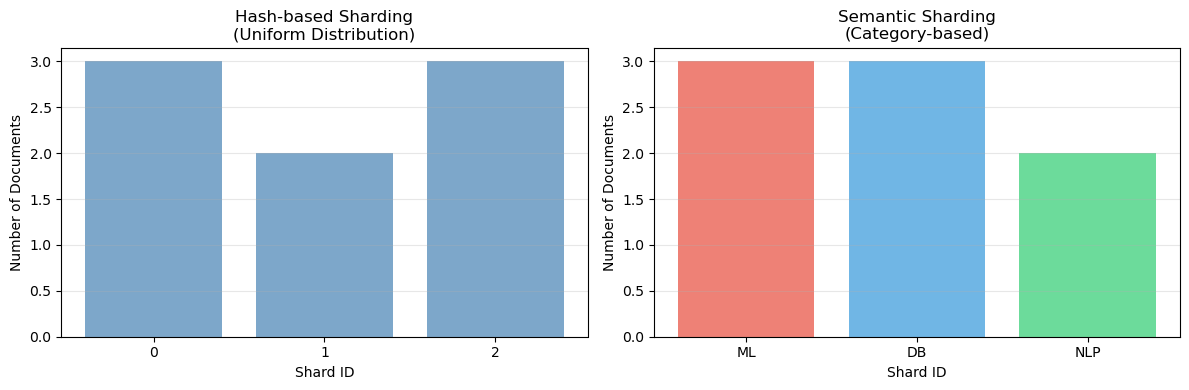

In [11]:
# Example: Simulating sharding strategies
import numpy as np
import hashlib

def hash_shard(doc_id, num_shards):
    """Hash-based sharding"""
    hash_val = int(hashlib.md5(doc_id.encode()).hexdigest(), 16)
    return hash_val % num_shards

def semantic_shard(doc_category, category_to_shard):
    """Semantic/category-based sharding"""
    return category_to_shard.get(doc_category, 0)

# Sample documents
documents = [
    {"id": "doc1", "category": "ML", "title": "Neural Networks"},
    {"id": "doc2", "category": "ML", "title": "Deep Learning"},
    {"id": "doc3", "category": "DB", "title": "Vector Databases"},
    {"id": "doc4", "category": "DB", "title": "Indexing Strategies"},
    {"id": "doc5", "category": "NLP", "title": "Transformers"},
    {"id": "doc6", "category": "NLP", "title": "Text Embeddings"},
    {"id": "doc7", "category": "ML", "title": "CNNs"},
    {"id": "doc8", "category": "DB", "title": "Query Optimization"},
]

num_shards = 3
category_to_shard = {"ML": 0, "DB": 1, "NLP": 2}

print("\n🔀 Sharding Strategies Comparison\n")
print("=" * 70)

# Hash sharding
print("\nHash-based Sharding:")
hash_shards = {i: [] for i in range(num_shards)}
for doc in documents:
    shard = hash_shard(doc["id"], num_shards)
    hash_shards[shard].append(doc["id"])

for shard_id, docs in hash_shards.items():
    print(f"  Shard {shard_id}: {docs}")

# Semantic sharding
print("\nSemantic Sharding (by category):")
semantic_shards = {i: [] for i in range(num_shards)}
for doc in documents:
    shard = semantic_shard(doc["category"], category_to_shard)
    semantic_shards[shard].append(f"{doc['id']} ({doc['category']})")

for shard_id, docs in semantic_shards.items():
    categories = ["ML", "DB", "NLP"]
    print(f"  Shard {shard_id} [{categories[shard_id]}]: {docs}")

print("\n" + "=" * 70)
print("\n💡 Trade-offs:")
print("  • Hash sharding: Uniform load, requires fan-out for category queries")
print("  • Semantic sharding: Targeted queries, but potential load imbalance")
print("  • Hybrid: Use semantic for common patterns, hash for others")

# Visualize distribution
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Hash sharding distribution
hash_counts = [len(hash_shards[i]) for i in range(num_shards)]
ax1.bar(range(num_shards), hash_counts, color='steelblue', alpha=0.7)
ax1.set_xlabel('Shard ID')
ax1.set_ylabel('Number of Documents')
ax1.set_title('Hash-based Sharding\n(Uniform Distribution)')
ax1.set_xticks(range(num_shards))
ax1.grid(True, alpha=0.3, axis='y')

# Semantic sharding distribution
semantic_counts = [len(semantic_shards[i]) for i in range(num_shards)]
colors = ['#e74c3c', '#3498db', '#2ecc71']
ax2.bar(range(num_shards), semantic_counts, color=colors, alpha=0.7)
ax2.set_xlabel('Shard ID')
ax2.set_ylabel('Number of Documents')
ax2.set_title('Semantic Sharding\n(Category-based)')
ax2.set_xticks(range(num_shards))
ax2.set_xticklabels(['ML', 'DB', 'NLP'])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('sharding_strategies.png', dpi=100, bbox_inches='tight')
plt.show()

# Challenges & How to Handle Them

| Challenge | Why it hurts | Mitigation |
|-----------|--------------|------------|
| **Recall–latency trade-off** | Higher efSearch/nprobe → slower queries | Tune per route (mobile vs internal tool); two-stage ranking with fast first-pass |
| **Filters with ANN** | Index isn't filter-aware, breaks assumptions | Pre-partition by key filters; maintain per-segment indexes; post-filter with larger candidate lists |
| **Drift / re-embeddings** | Embedding versions incompatible, breaks search | Versioned vector fields; dual-write during transition; gradual cutover with monitoring |
| **Quantization error** | PQ shrinks vectors, may lose nuance | Use OPQ (learned rotation); mixed precision (PQ for recall@100, float for re-rank) |
| **Deletions** | HNSW lazy deletes leave "ghost" nodes | Periodic rebuild/compaction; tombstone pruning; maintain delete bitmap |

# Practical Sizing & Tuning Cheatsheet

A quick reference guide for getting started with vector database configuration.

## Initial Setup Checklist

✅ **Pick metric early** (cosine vs L2 vs MIPS)
- Cosine: Most common for text/semantic search
- L2: When magnitude matters
- MIPS: For asymmetric similarity tasks

✅ **Choose index based on scale:**

**≤ 50M vectors, RAM-based:**
```python
# HNSW configuration
index = HNSWIndex(
    dim=768,
    M=16,                    # Start with 16-32
    efConstruction=200,      # 200-400 for good recall
    efSearch=64,             # Tune based on latency SLO
    metric='cosine'
)
```

**50M–1B vectors or GPU:**
```python
# IVF-PQ configuration
nlist = int(np.sqrt(n_vectors))  # e.g., 31,623 for 1B vectors
index = IVFPQIndex(
    dim=768,
    nlist=nlist,
    nprobe=16,               # Start with 8-64
    m=64,                    # PQ subvectors
    nbits=8,                 # bits per subvector
    metric='cosine'
)
```

## Tuning for Latency SLO

**Target: 95% recall@k with P95 latency < threshold**

1. **Baseline:** Start with conservative params
2. **Measure:** Run benchmark queries, measure recall & latency
3. **Iterate:** Gradually increase efSearch/nprobe
4. **Monitor:** Stop when latency SLO is met or recall plateaus

```python
# Example tuning loop
params = [32, 64, 128, 256, 512]
for ef in params:
    index.efSearch = ef
    recall, p95_latency = benchmark(index, test_queries)
    print(f"ef={ef}: recall={recall:.3f}, P95={p95_latency:.1f}ms")
    if recall >= 0.95 and p95_latency <= target_latency:
        break
```

## Hybrid Search Setup

```python
# Enable both vector and keyword search
config = {
    'vector_search': {
        'enabled': True,
        'weight': 0.7
    },
    'keyword_search': {
        'enabled': True,
        'algorithm': 'BM25',
        'weight': 0.3
    },
    'fusion_method': 'RRF',  # or 'weighted_sum'
    'reranker': {
        'model': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
        'top_k': 100  # Re-rank top 100 from fusion
    }
}
```

## Filter Configuration

```python
# Segment by common filters
filter_strategy = {
    'tenant_id': 'pre_partition',     # High cardinality
    'language': 'segment_index',      # Low cardinality (10-20 values)
    'publish_date': 'post_filter',    # Range filter
    'category': 'segment_index'       # Common query pattern
}
```

## Operational Monitoring

**Key metrics to track:**

```python
metrics = {
    # Quality
    'recall_at_10': target >= 0.95,
    'ndcg_at_10': target >= 0.85,
    
    # Performance
    'p50_latency_ms': target <= 20,
    'p95_latency_ms': target <= 50,
    'p99_latency_ms': target <= 100,
    'qps': target >= 1000,
    
    # Resource
    'memory_per_million_vectors_gb': monitor,
    'gpu_utilization_%': target >= 70,
    'cache_hit_rate_%': target >= 80,
    
    # Operations
    'index_freshness_lag_seconds': target <= 300,
    'failed_query_rate_%': target <= 0.1,
}
```

## Blue-Green Deployment

```python
# Version transition workflow
deployment = {
    'phase_1_dual_write': {
        'duration': '1 week',
        'write_to': ['index_v1', 'index_v2'],
        'read_from': 'index_v1',
        'traffic_split': {'v1': 100, 'v2': 0}
    },
    'phase_2_canary': {
        'duration': '3 days',
        'traffic_split': {'v1': 95, 'v2': 5},
        'monitor': ['recall', 'latency', 'error_rate']
    },
    'phase_3_ramp': {
        'duration': '1 week',
        'traffic_split': {'v1': 50, 'v2': 50},
    },
    'phase_4_cutover': {
        'traffic_split': {'v1': 0, 'v2': 100},
        'deprecate': 'index_v1'
    }
}
```

# Minimal Example with FAISS

Let's build a complete working example using FAISS, one of the most popular vector search libraries.

## Installation

```bash
# CPU version
pip install faiss-cpu

# GPU version (if CUDA is available)
pip install faiss-gpu
```

## Complete IVF-PQ Implementation

Below is a production-style implementation using FAISS with IVF-PQ indexing.

Vector Database with FAISS: Complete Example

📊 Step 1: Generating synthetic embeddings...
  ✓ Created 100,000 database vectors
  ✓ Created 100 query vectors
  ✓ Dimension: 768
  ✓ Memory footprint: 292.97 MB

🏗️  Step 2: Building IVF-PQ index...
  • Training index with nlist=256, m=64, nbits=8...
  ✓ Created 100,000 database vectors
  ✓ Created 100 query vectors
  ✓ Dimension: 768
  ✓ Memory footprint: 292.97 MB

🏗️  Step 2: Building IVF-PQ index...
  • Training index with nlist=256, m=64, nbits=8...
  ✓ Training completed in 74.89 seconds
  • Adding 100,000 vectors...
  ✓ Training completed in 74.89 seconds
  • Adding 100,000 vectors...
  ✓ Vectors added in 2.02 seconds
  ✓ Index contains 100,000 vectors

🔍 Step 3: Performing search...
  • Search parameters: nprobe=16, k=10
  ✓ Searched 100 queries in 30.00 ms
  ✓ Throughput: 3334 QPS
  ✓ Average latency: 0.30 ms per query

📋 Step 4: Sample results...

First query results:
  Top-10 neighbor IDs: [37887 91949 41194 83788 94566 41790  

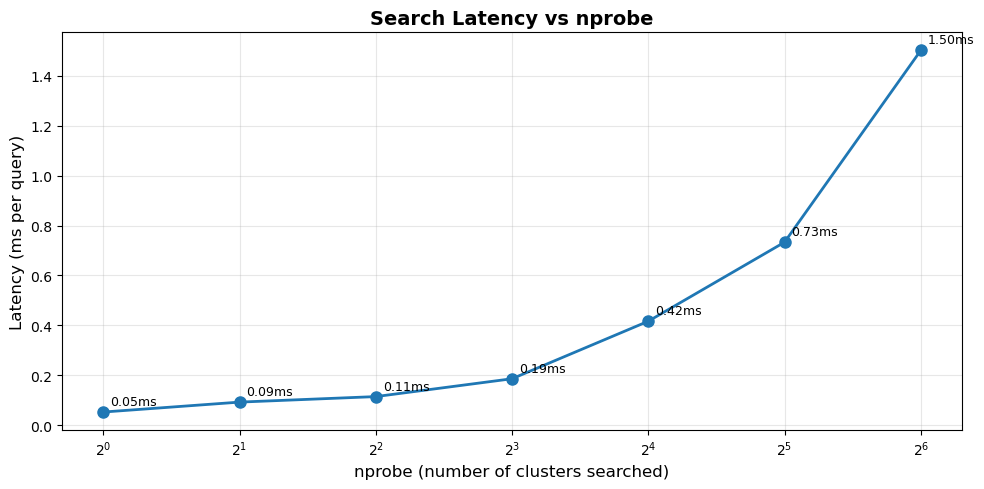


✅ FAISS example completed successfully!


In [12]:
# Complete FAISS example with IVF-PQ indexing
# Note: Install faiss-cpu first: pip install faiss-cpu numpy

import numpy as np
import time

# For visualization
import matplotlib.pyplot as plt

print("=" * 70)
print("Vector Database with FAISS: Complete Example")
print("=" * 70)

# ============================================================================
# Step 1: Generate synthetic embeddings
# ============================================================================
print("\n📊 Step 1: Generating synthetic embeddings...")

np.random.seed(42)
d = 768  # embedding dimension (typical for sentence transformers)
nb = 100000  # number of vectors in the database
nq = 100  # number of queries

# Create synthetic embeddings (in practice, use real embedding models)
xb = np.random.randn(nb, d).astype('float32')
xq = np.random.randn(nq, d).astype('float32')

# Normalize for cosine similarity (important!)
xb = xb / np.linalg.norm(xb, axis=1, keepdims=True)
xq = xq / np.linalg.norm(xq, axis=1, keepdims=True)

print(f"  ✓ Created {nb:,} database vectors")
print(f"  ✓ Created {nq:,} query vectors")
print(f"  ✓ Dimension: {d}")
print(f"  ✓ Memory footprint: {xb.nbytes / 1024**2:.2f} MB")

# ============================================================================
# Step 2: Build the index
# ============================================================================
print("\n🏗️  Step 2: Building IVF-PQ index...")

try:
    import faiss
    
    # IVF-PQ parameters
    nlist = 256  # number of clusters (cells)
    m = 64       # number of subquantizers (must divide d evenly)
    nbits = 8    # bits per subquantizer
    
    # Create quantizer (for coarse search)
    quantizer = faiss.IndexFlatIP(d)  # Inner Product = cosine for normalized vectors
    
    # Create IVF-PQ index
    index = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits)
    
    # Train the index (k-means + PQ training)
    print(f"  • Training index with nlist={nlist}, m={m}, nbits={nbits}...")
    start = time.time()
    index.train(xb)
    train_time = time.time() - start
    print(f"  ✓ Training completed in {train_time:.2f} seconds")
    
    # Add vectors to the index
    print(f"  • Adding {nb:,} vectors...")
    start = time.time()
    index.add(xb)
    add_time = time.time() - start
    print(f"  ✓ Vectors added in {add_time:.2f} seconds")
    print(f"  ✓ Index contains {index.ntotal:,} vectors")
    
    # ============================================================================
    # Step 3: Search
    # ============================================================================
    print("\n🔍 Step 3: Performing search...")
    
    # Set search parameters
    index.nprobe = 16  # number of clusters to search (recall/latency trade-off)
    k = 10  # return top-10 neighbors
    
    print(f"  • Search parameters: nprobe={index.nprobe}, k={k}")
    
    # Perform search
    start = time.time()
    scores, indices = index.search(xq, k)
    search_time = time.time() - start
    
    print(f"  ✓ Searched {nq} queries in {search_time*1000:.2f} ms")
    print(f"  ✓ Throughput: {nq/search_time:.0f} QPS")
    print(f"  ✓ Average latency: {search_time/nq*1000:.2f} ms per query")
    
    # ============================================================================
    # Step 4: Display results
    # ============================================================================
    print("\n📋 Step 4: Sample results...")
    print("\nFirst query results:")
    print(f"  Top-{k} neighbor IDs: {indices[0]}")
    print(f"  Top-{k} scores: {scores[0].round(4)}")
    
    # ============================================================================
    # Step 5: Tune nprobe for recall/latency trade-off
    # ============================================================================
    print("\n⚙️  Step 5: Tuning nprobe parameter...")
    
    nprobe_values = [1, 2, 4, 8, 16, 32, 64]
    latencies = []
    
    for nprobe in nprobe_values:
        index.nprobe = nprobe
        start = time.time()
        _, _ = index.search(xq[:10], k)  # Test with 10 queries
        elapsed = (time.time() - start) / 10 * 1000  # ms per query
        latencies.append(elapsed)
    
    # Plot results
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(nprobe_values, latencies, marker='o', linewidth=2, markersize=8)
    ax.set_xlabel('nprobe (number of clusters searched)', fontsize=12)
    ax.set_ylabel('Latency (ms per query)', fontsize=12)
    ax.set_title('Search Latency vs nprobe', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)
    
    # Annotate points
    for i, (np_val, lat) in enumerate(zip(nprobe_values, latencies)):
        ax.annotate(f'{lat:.2f}ms', 
                   xy=(np_val, lat), 
                   xytext=(5, 5), 
                   textcoords='offset points',
                   fontsize=9)
    
    plt.tight_layout()
    plt.savefig('faiss_nprobe_tuning.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("\n" + "=" * 70)
    print("✅ FAISS example completed successfully!")
    print("=" * 70)
    
except ImportError:
    print("\n⚠️  FAISS not installed. Install with: pip install faiss-cpu")
    print("\nHere's what the code would do:")
    print("  1. Create an IVF-PQ index with cosine similarity")
    print("  2. Train the index on 100K vectors")
    print("  3. Perform fast approximate nearest neighbor search")
    print("  4. Demonstrate recall/latency trade-offs")
except Exception as e:
    print(f"\n❌ Error: {e}")
    print("This example requires FAISS. Install with: pip install faiss-cpu")

## Notes on Production Usage

**Metadata Filtering:**
FAISS doesn't natively support metadata filters. Common approaches:
- Use an external database (PostgreSQL, Redis) for metadata
- Filter results after retrieval (post-filtering)
- Use wrapper libraries like LanceDB or Qdrant that support filters

**Hybrid Search:**
Combine FAISS with traditional search engines:
```python
# Pseudo-code
vector_results = faiss_index.search(query_embedding, k=100)
keyword_results = elasticsearch.search(query_text, size=100)
final_results = reciprocal_rank_fusion([vector_results, keyword_results])
```

**Persistence:**
```python
# Save index
faiss.write_index(index, "vector_index.faiss")

# Load index
index = faiss.read_index("vector_index.faiss")
```

**Cross-Encoder Re-ranking:**
```python
from sentence_transformers import CrossEncoder

# Get candidates from FAISS
candidates = index.search(query_vec, k=100)

# Re-rank with cross-encoder
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
scores = reranker.predict([(query_text, doc_text) for doc_text in candidate_docs])
final_results = sort_by_scores(candidates, scores)[:10]
```

# Frequently Asked Questions (FAQ)

## Q1: Do I always need a vector database?

**A:** Not for small corpora. For datasets with < 10,000 documents:
- Exact search or in-memory libraries may suffice
- Search libraries with vector support (Elasticsearch/OpenSearch) work well
- Scale, latency requirements, filter complexity, and operational needs drive the decision

**When you DO need a dedicated vector DB:**
- Millions+ of vectors
- Strict latency requirements (< 50ms P95)
- Complex metadata filtering
- High QPS (hundreds to thousands)
- Need for advanced features (hybrid search, re-ranking, analytics)

---

## Q2: Cosine vs Inner Product vs L2 — which should I use?

**A:** It depends on your embedding model and task:

**Cosine Similarity:**
- Best for: Text embeddings, semantic search
- Requires: Normalized vectors
- Properties: Magnitude-invariant, captures direction

**Inner Product (MIPS):**
- Best for: When you normalize vectors (equivalent to cosine)
- Use case: Asymmetric similarity tasks
- Note: Faster than cosine if vectors are pre-normalized

**L2 Distance:**
- Best for: When magnitude carries meaning
- Use case: Some vision tasks, specific embedding schemes
- Properties: Sensitive to scale

**Rule of thumb:** For most NLP/text applications, use cosine (with normalization).

---

## Q3: Can I mix different embedding models in one index?

**A:** Generally **avoid mixing incompatible embedding spaces**:

**Problem:**
- Different models create incompatible vector spaces
- Distances become meaningless across model boundaries

**Solutions:**
1. **Separate indexes per model:** Shard by `model_version`, merge results in application
2. **Re-embed everything:** When upgrading models, re-process entire corpus
3. **Dual-write pattern:** Maintain both versions during transition

```python
# Example: Separate indexes
results_v1 = index_v1.search(query_v1, k=20)
results_v2 = index_v2.search(query_v2, k=20)
final = merge_and_dedupe(results_v1, results_v2)
```

---

## Q4: How big should text chunks be?

**A:** Common practice: **256–1024 tokens with 20–30% overlap**

**Considerations:**

| Chunk Size | Pros | Cons |
|-----------|------|------|
| Small (128-256) | Precise matches, less noise | May lack context |
| Medium (512) | Good balance | Standard choice |
| Large (1024+) | Rich context | May be too general |

**Best practice:**
- Experiment with your specific use case
- Measure retrieval quality (recall, NDCG)
- Consider downstream task (Q&A needs precision, summarization needs context)
- Use overlap to prevent information loss at boundaries

---

## Q5: What about GPU vs CPU for vector search?

**A:** Choose based on workload characteristics:

**GPU Advantages:**
- Massive parallelism for batch queries
- Excellent for IVF-PQ indexes
- Great for re-ranking large candidate sets
- Cost-effective at very high QPS

**CPU Advantages:**
- HNSW performs well on CPU
- Lower latency for single queries
- Easier deployment and scaling
- More flexible for diverse workloads

**Hybrid Approach:**
- Use CPU for HNSW-based serving
- GPU for batch re-embedding and index building
- GPU for re-ranking top-k candidates

---

## Q6: How do I handle real-time updates?

**A:** Multiple strategies depending on freshness requirements:

**Streaming Upserts:**
```python
# Real-time updates with eventual consistency
index.upsert(doc_id, embedding, metadata)
# Visible within seconds to minutes
```

**Batch Updates:**
```python
# Periodic batch updates (hourly/daily)
new_embeddings = process_new_documents()
index.add_batch(new_embeddings)
```

**Blue-Green Deployment:**
```python
# For major rebuilds
1. Build new_index offline
2. Warm up new_index (cache, test queries)
3. Switch traffic: old_index → new_index
4. Deprecate old_index
```

---

## Q7: What's the best open-source vector database?

**A:** Depends on your requirements:

| Database | Best For | Key Strengths |
|----------|----------|---------------|
| **FAISS** | Research, prototyping | Performance, flexibility, GPU support |
| **Milvus** | Production scale | Distributed, cloud-native, rich features |
| **Qdrant** | Moderate scale | Easy API, good filtering, Rust performance |
| **Weaviate** | Hybrid search | GraphQL, modules, good docs |
| **Chroma** | RAG applications | Simple API, embeddings built-in |
| **Pinecone** | Managed service | Serverless, zero-ops, good DX |

---

## Q8: How do I debug poor recall?

**Checklist:**

1. ✅ **Check embeddings:** Are they normalized consistently?
2. ✅ **Verify metric:** Cosine vs L2 vs inner product
3. ✅ **Tune parameters:** Increase efSearch/nprobe
4. ✅ **Test with exact search:** Compare ANN vs brute force
5. ✅ **Inspect queries:** Are they in-distribution?
6. ✅ **Check filters:** Post-filtering too aggressive?
7. ✅ **Evaluate embedding model:** Is it appropriate for your domain?
8. ✅ **Look for drift:** Has data distribution changed?

**Diagnostic code:**
```python
# Compare ANN vs exact search
exact_neighbors = exact_index.search(query, k=10)
ann_neighbors = ann_index.search(query, k=10)
recall = len(set(exact_neighbors) & set(ann_neighbors)) / 10
print(f"Recall@10: {recall}")
```

# TL;DR - Key Takeaways

## 🎯 Core Concepts

✅ **Vector databases** enable semantic search by storing and querying high-dimensional embeddings

✅ **ANN (Approximate Nearest Neighbor)** indexes trade a small accuracy loss for massive speed gains

✅ **Distance metrics matter:** Cosine for text (normalized), L2 when magnitude matters, MIPS for specialized tasks

---

## 🏗️ Index Selection

| Scale | Recommendation | Key Parameters |
|-------|---------------|----------------|
| ≤ 50M | **HNSW** | M=16-32, efConstruction=200-400, efSearch=64-200 |
| 50M-1B | **IVF-PQ** | nlist=√N, nprobe=8-64, PQ 8-16 bits |
| Web-scale | **DiskANN** or sharded IVF-PQ | + tiered storage, caching |

---

## ⚙️ Production Essentials

1. **Hybrid search:** Combine vector + keyword (BM25) with RRF fusion
2. **Metadata filters:** Pre-partition by common filters or post-filter with larger k
3. **Re-ranking:** Use cross-encoders on top-100 for precision
4. **Monitoring:** Track recall@k, latency (P50/P95), QPS, and business metrics
5. **Versioning:** Dual-write during model transitions, blue-green deployment

---

## 🔍 Evaluation Framework

```python
# Essential metrics
- Recall@k (≥ 0.95 target)
- NDCG@k (for ranking quality)
- P95 latency (< 50ms typical)
- Cost per million vectors
- User engagement (CTR, task success)
```

---

## 🚀 Getting Started

**Step 1:** Choose your metric (cosine for most text tasks)

**Step 2:** Start simple:
- Small scale: HNSW with default params
- Large scale: IVF-PQ on GPU

**Step 3:** Measure baseline (recall, latency, cost)

**Step 4:** Iterate:
- Tune efSearch/nprobe for recall/latency balance
- Add hybrid search if keywords matter
- Implement re-ranking for precision

**Step 5:** Operationalize:
- Monitor key metrics
- Set up alerts for recall degradation
- Plan for model version migrations
- Implement caching and sharding strategies

---

## 💡 Common Pitfalls to Avoid

❌ Mixing normalized and unnormalized vectors

❌ Ignoring metadata filters in initial design

❌ Not measuring recall against exact search baseline

❌ Underestimating memory requirements

❌ Forgetting about the cold start problem

❌ No plan for embedding model versioning

❌ Optimizing for accuracy without considering latency

---

## 📚 Further Reading

- **FAISS documentation:** Facebook's high-performance library
- **HNSW paper:** Malkov & Yashunin (2018)
- **Vector DB benchmarks:** ann-benchmarks.com
- **Embedding models:** MTEB leaderboard
- **Production patterns:** MLOps best practices for vector search

---

## 🎓 Final Thoughts

Vector databases are a critical infrastructure component for modern AI applications. Success requires:

1. **Understanding the fundamentals:** embeddings, distances, indexes
2. **Making informed trade-offs:** recall vs latency vs cost
3. **Measuring what matters:** establish metrics before optimization
4. **Planning for operations:** versioning, monitoring, scaling
5. **Iterating based on data:** A/B test, measure, improve

**Start simple, measure everything, scale gradually.**

---

## 📬 Questions or Feedback?

This post covered the essentials of vector databases from theory to production. Key resources:

- 📖 **Code examples:** All examples available in this notebook
- 🔬 **Benchmarks:** Test different indexes with your data
- 📊 **Monitoring:** Set up dashboards for key metrics
- 🚀 **Deployment:** Start with managed solutions, self-host when needed

**Good luck building your vector search system!** 🎉

In [13]:
# Summary: Quick reference for vector database operations
import pandas as pd

print("\n" + "=" * 70)
print(" VECTOR DATABASES DEMYSTIFIED - QUICK REFERENCE ".center(70))
print("=" * 70)

# Create a reference table
reference_data = {
    'Task': [
        'Text embedding',
        'Image embedding',
        'Small scale (<10M)',
        'Large scale (>100M)',
        'Hybrid search',
        'Metadata filtering',
        'Real-time updates',
        'Production monitoring'
    ],
    'Recommended Approach': [
        'sentence-transformers, OpenAI, Cohere',
        'CLIP, vision transformers',
        'HNSW (M=16-32, ef=100-200)',
        'IVF-PQ (nlist=√N, nprobe=16-64)',
        'RRF fusion + cross-encoder re-rank',
        'Pre-partition or segment indexes',
        'Streaming upsert + dual-write pattern',
        'Recall@k, P95 latency, QPS, drift'
    ],
    'Key Metric': [
        'Embedding quality',
        'Multimodal alignment',
        'Recall@10 > 0.95',
        'QPS > 1000',
        'NDCG@10 > 0.85',
        'Filter selectivity',
        'Freshness lag < 5min',
        'All of the above'
    ]
}

df = pd.DataFrame(reference_data)
print("\n")
print(df.to_string(index=False))

print("\n" + "=" * 70)
print("\n💡 Key Reminders:")
print("  1. Always normalize vectors for cosine similarity")
print("  2. Measure recall against exact search baseline")
print("  3. Tune efSearch/nprobe to meet latency SLO")
print("  4. Use hybrid search for production systems")
print("  5. Monitor, version, and iterate")
print("\n" + "=" * 70)
print("\n✅ You're ready to build production vector search systems!")
print("=" * 70 + "\n")


            VECTOR DATABASES DEMYSTIFIED - QUICK REFERENCE            


                 Task                  Recommended Approach           Key Metric
       Text embedding sentence-transformers, OpenAI, Cohere    Embedding quality
      Image embedding             CLIP, vision transformers Multimodal alignment
   Small scale (<10M)            HNSW (M=16-32, ef=100-200)     Recall@10 > 0.95
  Large scale (>100M)       IVF-PQ (nlist=√N, nprobe=16-64)           QPS > 1000
        Hybrid search    RRF fusion + cross-encoder re-rank       NDCG@10 > 0.85
   Metadata filtering      Pre-partition or segment indexes   Filter selectivity
    Real-time updates Streaming upsert + dual-write pattern Freshness lag < 5min
Production monitoring     Recall@k, P95 latency, QPS, drift     All of the above


💡 Key Reminders:
  1. Always normalize vectors for cosine similarity
  2. Measure recall against exact search baseline
  3. Tune efSearch/nprobe to meet latency SLO
  4. Use hybrid search for pro